In [1]:
from sklearn.model_selection import train_test_split
from glob import glob
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from scipy.fftpack import fft, ifft
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import os

In [2]:
def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

In [3]:
def prepare_data_test(fname):
    # Read data
    data = pd.read_csv(fname)
    return data

In [5]:
def butter_bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(12, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

In [6]:
scaler= StandardScaler()
def data_normaliz(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep

In [7]:
subjects = range(1,2)
y_raw= []
raw = []
y_rawt= []
rawt = []

In [10]:
################ READ DATA #############################
for subject in subjects:
    
    fnames =  sorted(glob('C:\\Users\\saara\\train/subj%d_series*_data.csv' % (subject)))

    for fname in fnames:
      data,labels=prepare_data_train(fname)
      raw.append(data)
      y_raw.append(labels)

    for fname in fnames:
      with open(fname) as myfile:
        head = [next(myfile) for x in range(10)]
               
X = pd.concat(raw)
y = pd.concat(y_raw)
#transform in numpy array
#transform train data in numpy array
X_train =np.asarray(X.astype(float))
y_train = np.asarray(y.astype(float))

In [11]:
fnames


['C:\\Users\\saara\\train\\subj1_series1_data.csv',
 'C:\\Users\\saara\\train\\subj1_series2_data.csv',
 'C:\\Users\\saara\\train\\subj1_series3_data.csv',
 'C:\\Users\\saara\\train\\subj1_series4_data.csv',
 'C:\\Users\\saara\\train\\subj1_series5_data.csv',
 'C:\\Users\\saara\\train\\subj1_series6_data.csv',
 'C:\\Users\\saara\\train\\subj1_series7_data.csv',
 'C:\\Users\\saara\\train\\subj1_series8_data.csv']

In [12]:
x_filter=butter_bandpass_filter(X_train,7,30,500)


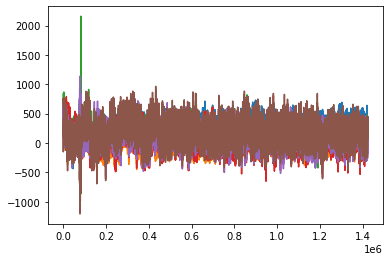

In [13]:
plt.plot(X_train)


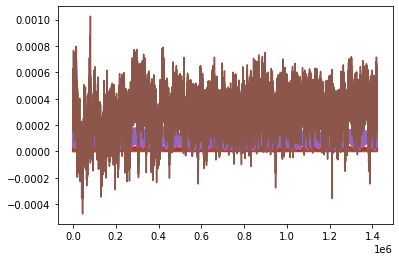

In [14]:
plt.plot(x_filter)


In [15]:
x_filter_normaliz=data_normaliz(x_filter)


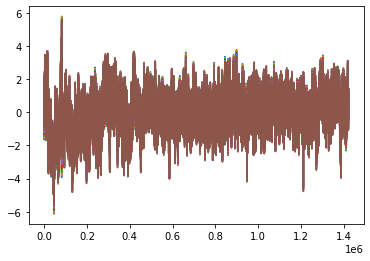

In [16]:
plt.plot(x_filter_normaliz)


In [17]:
x_filter_normaliz


array([[-0.79706799, -0.67946207, -0.54874819, -0.40569006, -0.25164765,
        -0.08861286],
       [-0.72076383, -0.60334667, -0.47374866, -0.33286753, -0.18216729,
        -0.0237045 ],
       [-0.74619855, -0.63843652, -0.51867239, -0.38764684, -0.24665267,
        -0.09757212],
       ...,
       [ 0.24575547,  0.23988931,  0.23316663,  0.22550676,  0.21674879,
         0.20668527],
       [ 0.13553835,  0.13085185,  0.12514127,  0.11829286,  0.11012721,
         0.10043682],
       [ 0.00836476,  0.00204923, -0.00467003, -0.01196509, -0.0201286 ,
        -0.02952893]])

In [18]:
# access first col , electrode C3 
x_filter_normaliz[:,0]

array([-0.79706799, -0.72076383, -0.74619855, ...,  0.24575547,
        0.13553835,  0.00836476])

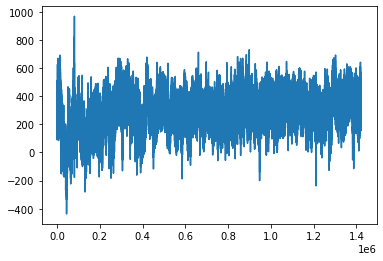

In [19]:
plt.plot(X_train[:,0])


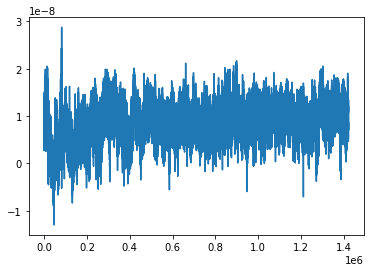

In [20]:
plt.plot(x_filter[:,0])


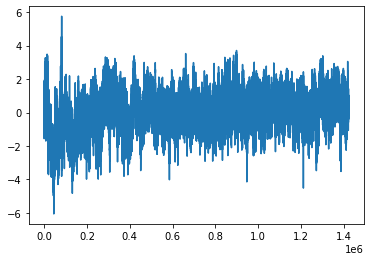

In [21]:
plt.plot(x_filter_normaliz[:,1])


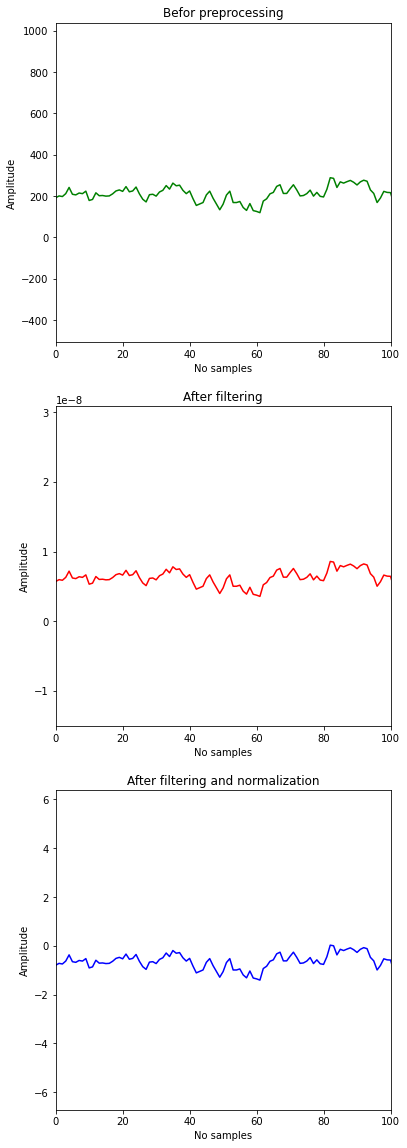

In [22]:
plt.figure(figsize = (6, 20))
plt.title("Electrode C3 for all 8 serries of subject 1",fontsize=20)
plt.subplot(311)
plt.plot(X_train[:,0],'g')
plt.title('Befor preprocessing')
plt.xlim(0, 100)
plt.xlabel('No samples')
plt.ylabel('Amplitude')
plt.savefig('Befor preprocessing.png')

plt.subplot(312)
plt.plot(x_filter[:,0],'r')
plt.title('After filtering')
plt.xlim(0, 100)
plt.xlabel('No samples')
plt.ylabel('Amplitude')
plt.savefig('After filtering.png')

plt.subplot(313)
plt.plot(x_filter_normaliz[:,0],'b')
plt.title('After filtering and normalization')
plt.xlim(0, 100)
plt.xlabel('No samples')
plt.ylabel('Amplitude')
plt.savefig('After filtering and normalization.png')

In [23]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_custom_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

In [24]:
from sklearn.linear_model import LogisticRegression
from glob import glob

from scipy.signal import butter, lfilter, convolve, boxcar
from joblib import Parallel, delayed

In [31]:
def creat_mne_raw_object(fname,read_events=True):
    """Create a mne raw instance from csv file"""
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_custom_montage('standard_1005',ch_names)

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    info['filename'] = fname
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    
    return raw

In [32]:
subjects = range(1,13)
ids_tot = []
pred_tot = []

# design a butterworth bandpass filter 
freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')

# CSP parameters
# Number of spatial filter to use
nfilters = 4

# convolution
# window for smoothing features
nwin = 250

# training subsample
subsample = 10


In [33]:
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

for subject in subjects:
    epochs_tot = []
    y = []


In [34]:
################ READ DATA ################################################
fnames =  glob('C:\\Users\\saara\\train/subj%d_series*_data.csv' % (subject))
    
    # read and concatenate all the files
raw = concatenate_raws([creat_mne_raw_object(fname) for fname in fnames])
       
    # pick eeg signal
picks = pick_types(raw.info,eeg=True)
    
    # Filter data for alpha frequency and beta band
    # Note that MNE implement a zero phase (filtfilt) filtering not compatible
    # with the rule of future data.
    # Here we use left filter compatible with this constraint. 
    # The function parallelized for speeding up the script
raw._data[picks] = np.array(Parallel(n_jobs=-1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))

ValueError: Invalid value for the 'fname' parameter. Allowed values are '.loc', '.locs', '.eloc', '.sfp', '.csd', '.elc', '.txt', '.elp', '.bvef', '.csv', '.tsv', and '.xyz', but got '' instead.